In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import pandas as pd
import math
from datetime import datetime
from operator import add
from pyspark.sql import *
from pyspark.sql.functions import col, max as max_
sc = pyspark.SparkContext.getOrCreate()
sqlContext = pyspark.sql.SQLContext(sc)

# Reading the 'population_india_census2011.csv' dataset to rdd
### Sanitizing population_rdd...


In [173]:
population_rdd = sc.textFile("/usr/data/kaggle/covid19-in-india/population_india_census2011.csv")

headers = population_rdd.first()
population_rdd = population_rdd.filter(lambda line: line != headers)
population_rdd = population_rdd.map(lambda line: line.split(","))
population_rdd = population_rdd.map(lambda line: (line[1], line[2], line[6]))
population_rdd = population_rdd.map(lambda line: (line[0], int(line[1]), math.ceil(float(line[2].split('/')[0]))))

print(f"Population RDD mentions data about {population_rdd.count()} states in India")

total_population = population_rdd.map(lambda line: line[1]).reduce(add)
print(f"Total aggregated population in all of the states in population RDD: {total_population}")

Population RDD mentions data about 36 states in India
Total aggregated population in all of the states in population RDD: 1210568111


### Converting population RDD to DataFrame and displaying...

In [174]:
population_df = population_rdd.toDF(["state", "population", "density"])
population_df.show()

+----------------+----------+-------+
|           state|population|density|
+----------------+----------+-------+
|   Uttar Pradesh| 199812341|    828|
|     Maharashtra| 112374333|    365|
|           Bihar| 104099452|   1102|
|     West Bengal|  91276115|   1029|
|  Madhya Pradesh|  72626809|    236|
|      Tamil Nadu|  72147030|    555|
|       Rajasthan|  68548437|    201|
|       Karnataka|  61095297|    319|
|         Gujarat|  60439692|    308|
|  Andhra Pradesh|  49577103|    303|
|          Odisha|  41974218|    269|
|       Telengana|  35003674|    312|
|          Kerala|  33406061|    859|
|       Jharkhand|  32988134|    414|
|           Assam|  31205576|    397|
|          Punjab|  27743338|    550|
|    Chhattisgarh|  25545198|    189|
|         Haryana|  25351462|    573|
|     Uttarakhand|  10086292|    189|
|Himachal Pradesh|   6864602|    123|
+----------------+----------+-------+
only showing top 20 rows



# Reading the 'covid_19_india.csv' dataset to rdd
####  Sanitizing covid-19 data and preparing covid-19 data

In [175]:
raw_covid_file = sc.textFile("/usr/data/kaggle/covid19-in-india/covid_19_india.csv")
headers = raw_covid_file.first()
raw_data = raw_covid_file.filter(lambda line: line != headers)
split_covid_data = raw_data.map(lambda line: line.split(","))
sanitized_covid_data = split_covid_data.map(lambda line: (line[3], datetime.strptime(line[1], '%d/%m/%y'), int(line[6]), int(line[7]), int(line[8])))

### Converting sanitized covid data's RDD to DataFrame and displaying...

In [176]:
covid_df = sanitized_covid_data.toDF(["state", "datetime", "cured", "deaths", "confirmed"])
covid_df.show()

+------+-------------------+-----+------+---------+
| state|           datetime|cured|deaths|confirmed|
+------+-------------------+-----+------+---------+
|Kerala|2020-01-30 00:00:00|    0|     0|        1|
|Kerala|2020-01-31 00:00:00|    0|     0|        1|
|Kerala|2020-02-01 00:00:00|    0|     0|        2|
|Kerala|2020-02-02 00:00:00|    0|     0|        3|
|Kerala|2020-02-03 00:00:00|    0|     0|        3|
|Kerala|2020-02-04 00:00:00|    0|     0|        3|
|Kerala|2020-02-05 00:00:00|    0|     0|        3|
|Kerala|2020-02-06 00:00:00|    0|     0|        3|
|Kerala|2020-02-07 00:00:00|    0|     0|        3|
|Kerala|2020-02-08 00:00:00|    0|     0|        3|
|Kerala|2020-02-09 00:00:00|    0|     0|        3|
|Kerala|2020-02-10 00:00:00|    0|     0|        3|
|Kerala|2020-02-11 00:00:00|    0|     0|        3|
|Kerala|2020-02-12 00:00:00|    0|     0|        3|
|Kerala|2020-02-13 00:00:00|    0|     0|        3|
|Kerala|2020-02-14 00:00:00|    0|     0|        3|
|Kerala|2020

#### Grouping data by 'state' getting the latest (max) date for each state...


In [177]:
most_recent_date_by_state = covid_df.withColumn("datetime",  col("datetime")).\
                                    groupBy("state")\
                                    .agg(max_("datetime"))
most_recent_date_by_state.show()

+-----------------+-------------------+
|            state|      max(datetime)|
+-----------------+-------------------+
|        Nagaland#|2020-04-15 00:00:00|
|         Nagaland|2020-04-14 00:00:00|
|        Karnataka|2020-04-15 00:00:00|
|           Odisha|2020-04-15 00:00:00|
|           Kerala|2020-04-15 00:00:00|
|           Ladakh|2020-04-15 00:00:00|
|       Tamil Nadu|2020-04-15 00:00:00|
|        Telengana|2020-04-15 00:00:00|
|     Chhattisgarh|2020-04-15 00:00:00|
|   Andhra Pradesh|2020-04-15 00:00:00|
|   Madhya Pradesh|2020-04-15 00:00:00|
|           Punjab|2020-04-15 00:00:00|
|          Manipur|2020-04-15 00:00:00|
|              Goa|2020-04-15 00:00:00|
|          Mizoram|2020-04-15 00:00:00|
| Himachal Pradesh|2020-04-15 00:00:00|
|       Puducherry|2020-04-15 00:00:00|
|       Unassigned|2020-04-03 00:00:00|
|          Haryana|2020-04-15 00:00:00|
|Jammu and Kashmir|2020-04-15 00:00:00|
+-----------------+-------------------+
only showing top 20 rows



#### Join the covid_df (full table) with the partial table of most recent dates by state.
And then display that joined table in a nice Pandas format...

In [178]:
covid_df_latest_records = covid_df.join(most_recent_date_by_state, [(covid_df.state == most_recent_date_by_state.state) & (covid_df["datetime"]==most_recent_date_by_state["max(datetime)"])])\
.select(covid_df.state, "datetime", "cured", "deaths", "confirmed")
covid_df_latest_records.toPandas()

,state,datetime,cured,deaths,confirmed
0,Manipur,2020-04-15,1,0,2
1,Telengana,2020-04-15,120,18,647
2,Tripura,2020-04-15,0,0,2
3,West Bengal,2020-04-15,37,7,213
4,Rajasthan,2020-04-15,147,3,1005
5,Nagaland#,2020-04-15,0,0,0
6,Mizoram,2020-04-15,0,0,1
7,Assam,2020-04-15,0,1,33
8,Jammu and Kashmir,2020-04-15,30,4,278
9,Madhya Pradesh,2020-04-15,64,53,987


#### Joining the population data and the covid_df_latest_records and converting to Pandas object for easy plotting...

In [179]:
df = covid_df_latest_records.join(population_df, ["state"])
pd = df.toPandas()
pd

,state,datetime,cured,deaths,confirmed,population,density
0,Nagaland,2020-04-14,0,0,1,1978502,119
1,Karnataka,2020-04-15,75,11,277,61095297,319
2,Odisha,2020-04-15,18,1,60,41974218,269
3,Kerala,2020-04-15,211,3,387,33406061,859
4,Ladakh,2020-04-15,10,0,17,274000,3
5,Tamil Nadu,2020-04-15,81,12,1204,72147030,555
6,Telengana,2020-04-15,120,18,647,35003674,312
7,Chhattisgarh,2020-04-15,13,0,33,25545198,189
8,Andhra Pradesh,2020-04-15,16,9,503,49577103,303
9,Madhya Pradesh,2020-04-15,64,53,987,72626809,236


# Data insights
## Correlation
Correlation is measured between -1 and 1. As the value gets closer to 0, it's getting "loose"

#### Confirmed - Cured cases

In [71]:
print(f"confirmed and cured cases correlation: {pd['confirmed'].corr(pd['cured'])}\n"
      "As we can see, 0.747 is fairly high and even though this 'insight' is trivial it clearly demonstrate high correlation.")

confirmed and cured cases correlation: 0.7477287499967894
As we can see, 0.747 is fairly high and even though this 'insight' is trivial it clearly demonstrate high correlation.


### Scatter plot
#### Confirmed - Cured cases
We can see the strong connection between the two parameters in each state and notice that in the general case: 
as high as we go in the x axis, the higher y value the point gets

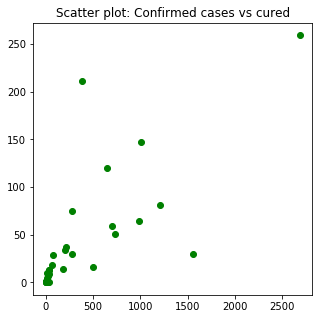

In [72]:
plt.figure(figsize=(5,5))
plt.scatter(pd["confirmed"], pd["cured"], color="g")
plt.title('Scatter plot: Confirmed cases vs cured')
plt.show()

### Correlation and scatter plot - confirmed and death cases
Now lets take a look at an even stronger correlation: Confirmed and Death cases

The correlation between Confirmed and Death cases: 0.8511584605156302

As we can see in confirmed-deaths scatter plot, all the dots are more centered and demonstrate a strong linear regression


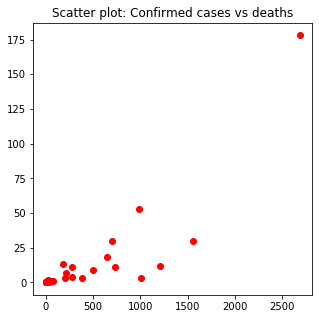

In [73]:
print(f"The correlation between Confirmed and Death cases: {pd['confirmed'].corr(pd['deaths'])}\n") 
print("As we can see in confirmed-deaths scatter plot, all the dots are more centered and demonstrate a strong linear regression")
plt.figure(figsize=(5,5))
plt.scatter(pd["confirmed"], pd["deaths"], color="r")
plt.title('Scatter plot: Confirmed cases vs deaths')
plt.show()

### A bit looser correlation
#### Confirmed VS population density

Confirmed-density correlation: 0.2181782035715635


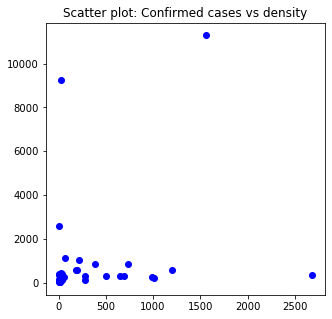

In [74]:
print(f"Confirmed-density correlation: {pd['confirmed'].corr(pd['density'])}") 
plt.figure(figsize=(5,5))
plt.scatter(pd["confirmed"], pd["density"], color="b")
plt.title('Scatter plot: Confirmed cases vs density')
plt.show()

## Combined Scatter plot:
#### confirmed VS density/deaths/cured
Notice that the red 'confirmed+deaths' dots are so densed they are almost totaly covered by the others

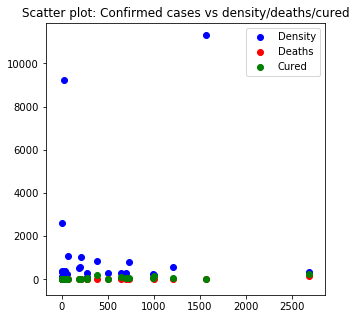

In [116]:
plt.figure(figsize=(5,5))
plt.scatter(pd["confirmed"], pd["density"], label="Density", color="b")
plt.scatter(pd["confirmed"], pd["deaths"], label="Deaths", color="r")
plt.scatter(pd["confirmed"], pd["cured"], label="Cured", color="g")
plt.legend()
plt.title('Scatter plot: Confirmed cases vs density/deaths/cured')
plt.show()

# Density Plots
### Confirmed VS Cured
As we can see, the vast majority of cured cases is densed around the zero. <br>
The average amount of confirmed cases is a bit higher than 0, with only some records (some states) of 2500.

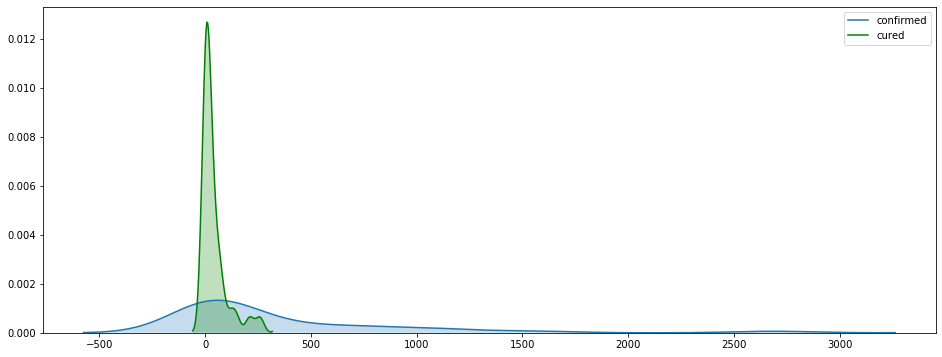

In [78]:
plt.figure(figsize=(16, 6))
sns.kdeplot(pd['confirmed'], shade=True)
sns.kdeplot(pd['cured'], shade=True, color="g")

### Confirmed Vs Deaths density plot
This plot shows even higher density around the value zero, as most of the states in india hasn't suffered a lot of casualties  yet

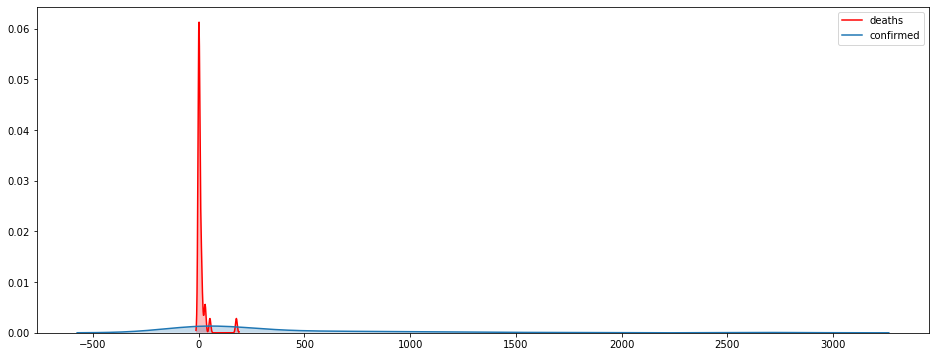

In [80]:
plt.figure(figsize=(16, 6))
sns.kdeplot(pd['deaths'], shade=True, color="r")
sns.kdeplot(pd['confirmed'], shade=True)

# Box plot
### Cured and Deaths cases

The following box plot describes the deviation of the cured and deaths records.

#### Cured:
Q1 (25%) of the states has 0 cured cases. <br>
The median value is somewhere around the 20 (green line) - half of the states in india has less than 20~ cured cases. <br>
The 75 percentile is at 51 and the maximum value is at 125~. <br>
This box shows 3 outliers.

#### Deaths:
Q1 (25%) of the states has 0 death cases. <br>
Median is at 1 (Go india!) <br>
The 75 percentile is at 11 and the "maximum" (excluding outliers) is around 15.

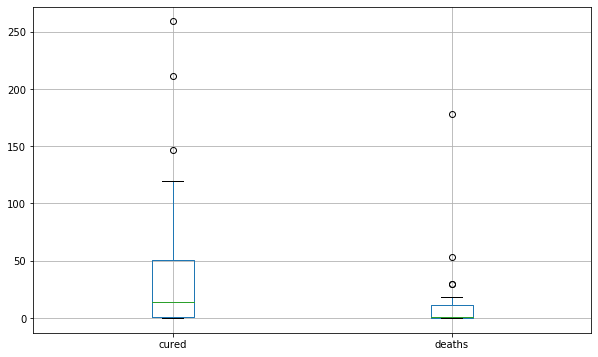

In [103]:
plt.figure(figsize=(10, 6))
pd[["cured", "deaths"]].boxplot()

# Data over time
## Confirmed cases in Delhi Vs the state of Uttarakhand
A quick look at this plot shows a hugh leap in the amount of confirmed cases in Delhi, <br>
Where Uttrakhand enjoys almost zero cases.

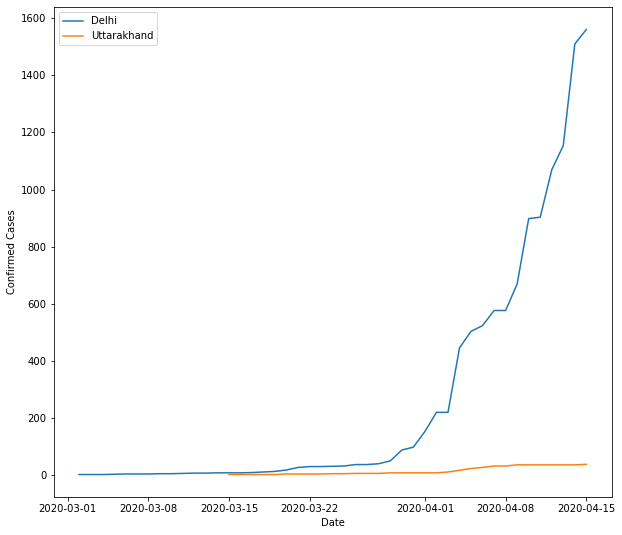

In [105]:
delhi_covid_overtime = covid_df.filter(covid_df.state=='Delhi').toPandas()
uttarakhand_covid_overtime = covid_df.filter(covid_df.state=='Uttarakhand').toPandas()

plt.figure(figsize=(10, 10))
plt.gcf().autofmt_xdate()
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')

plt.plot(delhi_covid_overtime.datetime, delhi_covid_overtime.confirmed, label="Delhi")
plt.plot(uttarakhand_covid_overtime.datetime, uttarakhand_covid_overtime.confirmed, label="Uttarakhand")
plt.legend()
plt.show()

### Assumption:
#### Its the population..? Spoiler - probably not...
One might claim that the un-equal growth is highly influenced by the huge difference in population sizes of both states <br>
A glance at this bar chart shows that the difference between Delhi and Uttarakhand is not that big

Text(0.5, 1.0, 'Delhi vs Utarakhand: Population in millions')

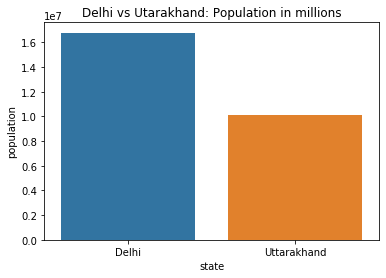

In [106]:
population_by_state = df.rdd.filter(lambda row: row.state in ["Delhi", "Uttarakhand"]).map(lambda row: (row.state, row.population)).toDF(["state", "population"]).toPandas()
sns.barplot(x='state', y='population', data=population_by_state).set_title("Delhi vs Utarakhand: Population in millions")

## Assumption 2
#### much more likely - Population Density
The Density difference of the two is much larger, and might have a greater influence on the differential growth

Text(0.5, 1.0, 'Delhi vs Utarakhand: Population Density (people per sqr KM)')

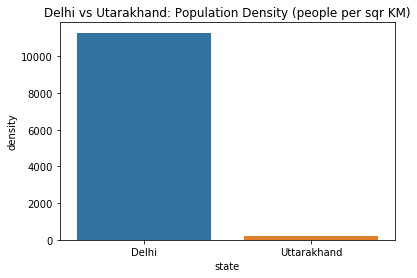

In [107]:
density_by_state = df.rdd.filter(lambda row: row.state in ["Delhi", "Uttarakhand"]).map(lambda row: (row.state, row.density)).toDF(["state", "density"]).toPandas()
sns.barplot(x='state', y='density', data=density_by_state).set_title("Delhi vs Utarakhand: Population Density (people per sqr KM)")

# Adding some data to spice up things
#### introducing: air quality in india!
I wanted to add some more interest to the data so I added a data set of air quality measurements in india
1. Reading the 'air-quality-in-india.csv' dataset to rdd
2. Sanitizing air_quality_rdd
3. Get the list of states from our old Dataframe, as list of strings
4. filter only records of states we previously investigated and converting to DF
5. Group by state and aggregate average values

In [108]:
from pyspark.sql.functions import col, to_date, coalesce, avg
from pyspark.sql.functions import unix_timestamp, from_unixtime
air_quality_rdd = sc.textFile("/usr/data/kaggle/air-quality-in-india.csv")

headers = air_quality_rdd.first()
air_quality_rdd = air_quality_rdd.filter(lambda line: line != headers)
air_quality_rdd = air_quality_rdd.map(lambda line: line.split(",")).filter(lambda line: line[7].isnumeric() and line[8].isnumeric() and line[9].isnumeric() and line[10].isnumeric())
air_quality_rdd = air_quality_rdd.map(lambda line: [line[1], line[2], float(line[7]), float(line[8]), float(line[9]), float(line[10])])

# Get the list of states from our old Dataframe, as list of strings
states = list(map(lambda x: x.state, df.select("state").collect()))

# Dealing with dates here is just for fun. there's no actual need for it since we're going to aggregate average (!)
# filter only records of states we previously investigated and converting to DF
air_quality_df = air_quality_rdd.filter(lambda x: x[1] in states).toDF(["date", "state", "SO2", "NO2", "RSPM", "SPM"])

# Converting date strings in a different method than before... (just for fun, there's no need for it here)
air_quality_df = air_quality_df.select("state", "SO2", "NO2", "RSPM", "SPM", to_date('date', 'MM/dd/yyy').alias('date1'), to_date('date', 'MM-dd-yyy').alias('date2')).where((col("date1").isNotNull()) | (col("date2").isNotNull()))
air_quality_df = air_quality_df.select(coalesce("date1", "date2").alias("date"), "state", "SO2", "NO2", "RSPM", "SPM")

air_quality_by_state = air_quality_df.groupBy("state").agg(avg("SO2"), avg("NO2"), avg("RSPM"), avg("SPM"))
air_quality_by_state.sort("state").show()

+--------------+------------------+------------------+------------------+------------------+
|         state|          avg(SO2)|          avg(NO2)|         avg(RSPM)|          avg(SPM)|
+--------------+------------------+------------------+------------------+------------------+
|Andhra Pradesh|  8.82857142857143|30.902857142857144| 93.54857142857144|172.86857142857144|
|         Bihar|11.839506172839506|25.209876543209877| 78.32098765432099|156.33333333333334|
|    Chandigarh|3.2133333333333334|             23.18|             97.46|178.36666666666667|
|         Delhi|               9.5|35.891304347826086|120.02173913043478| 286.4782608695652|
|           Goa| 7.517857142857143|13.553571428571429| 96.64285714285714| 36.82142857142857|
|       Gujarat|12.862302483069977|19.124153498871333| 88.20767494356659| 49.63431151241535|
|       Haryana|               6.0|              21.0|             129.0|             209.0|
|     Karnataka| 8.944444444444445| 33.94444444444444| 66.527777777777

### Join all the data we have together

In [111]:
joined_df_all_data = df.join(air_quality_by_state, ["state"]).sort("state")
joined_df_all_data.toPandas()

,state,datetime,cured,deaths,confirmed,population,density,avg(SO2),avg(NO2),avg(RSPM),avg(SPM)
0,Andhra Pradesh,2020-04-15,16,9,503,49577103,303,8.828571,30.902857,93.548571,172.868571
1,Bihar,2020-04-15,29,1,70,104099452,1102,11.839506,25.209877,78.320988,156.333333
2,Chandigarh,2020-04-15,7,0,21,1055450,9252,3.213333,23.180000,97.460000,178.366667
3,Delhi,2020-04-15,30,30,1561,16787941,11297,9.500000,35.891304,120.021739,286.478261
4,Goa,2020-04-15,5,0,7,1458545,394,7.517857,13.553571,96.642857,36.821429
5,Gujarat,2020-04-15,59,30,695,60439692,308,12.862302,19.124153,88.207675,49.634312
6,Haryana,2020-04-15,34,3,199,25351462,573,6.000000,21.000000,129.000000,209.000000
7,Karnataka,2020-04-15,75,11,277,61095297,319,8.944444,33.944444,66.527778,122.708333
8,Kerala,2020-04-15,211,3,387,33406061,859,3.632353,18.147059,50.039216,66.343137
9,Madhya Pradesh,2020-04-15,64,53,987,72626809,236,8.442509,13.268293,54.268293,110.247387


My guess was that there is a strong correlation between population density and air pollution
However, I guessed wrong and the correlation is not that strong, its just: 0.1283119589220432


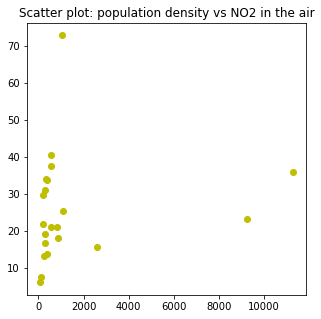

In [112]:
print("My guess was that there is a strong correlation between population density and air pollution")
pd_with_air = joined_df_all_data.toPandas()
print(f"However, I guessed wrong and the correlation is not that strong, its just: {pd_with_air['density'].corr(pd_with_air['avg(NO2)'])}")


plt.figure(figsize=(5,5))
plt.scatter(pd_with_air["density"], pd_with_air["avg(NO2)"], color="y")
plt.title('Scatter plot: population density vs NO2 in the air')
plt.show()

Same for confirmed cases and 'Sulphur dioxde'... loose correlation: 0.3084289405048287


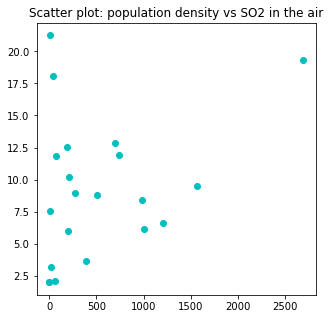

In [33]:
print(f"Same for confirmed cases and 'Sulphur dioxde'... loose correlation: {pd_with_air['confirmed'].corr(pd_with_air['avg(SO2)'])}")

plt.figure(figsize=(5,5))
plt.scatter(pd_with_air["confirmed"], pd_with_air["avg(SO2)"], color="c")
plt.title('Scatter plot: population density vs SO2 in the air')
plt.show()


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1084455a50>,
      dtype=object)

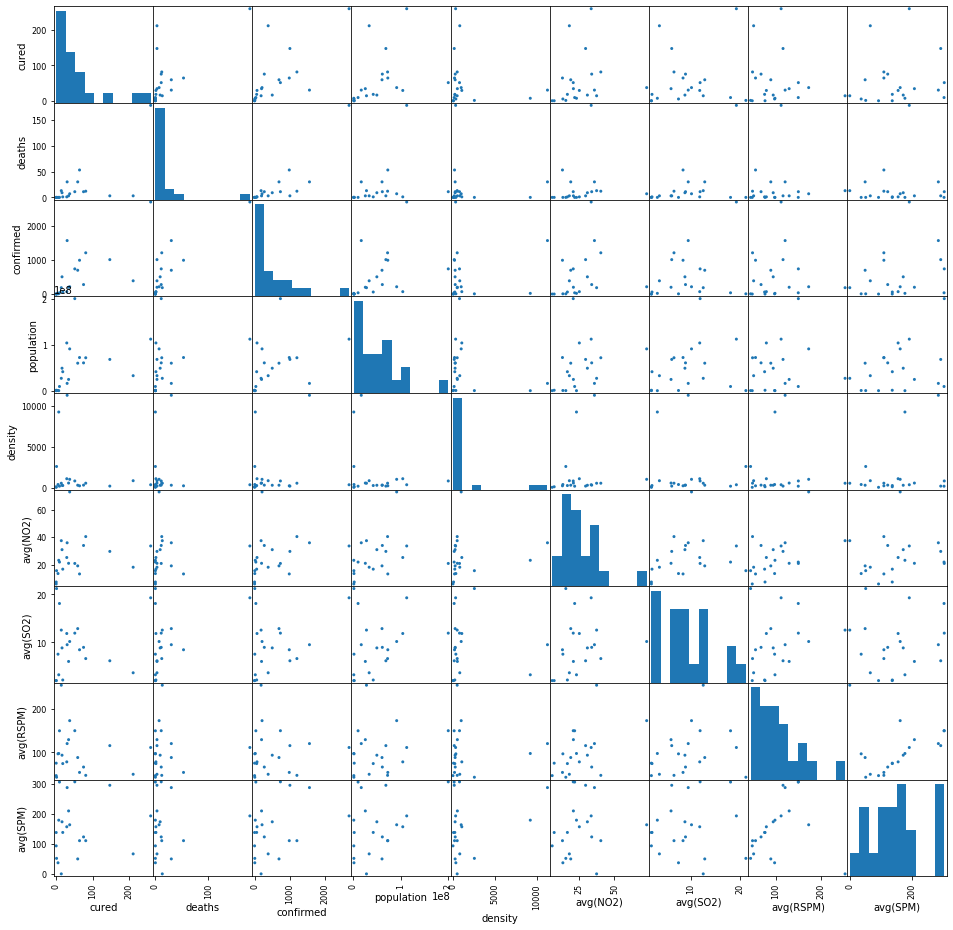

In [34]:
from pandas.plotting import scatter_matrix
scatter_matrix(pd_with_air[["cured", "deaths", "confirmed", "population", "density", "avg(NO2)", "avg(SO2)", "avg(RSPM)", "avg(SPM)"]], alpha=1, figsize=(16,16))

# Linear regression model
### Define our initial data
Let's take the joined table, and use it's equivalent RDD to iterate and create Labeled Points <br>
Notice that **cured and deaths** columns are sort of a "cheat", but since its an educational excercise lets add them to demonstrate stronger correlation

In [171]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
joined_rdd = joined_df_all_data.select("population", "density", "cured", "deaths", "avg(SO2)", "avg(NO2)", "avg(RSPM)", "avg(SPM)", "confirmed").rdd

### Generate Labeled points structure: Label + densed vectore

In [161]:
labeled_points = joined_rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))
labeled_points.take(5)

[LabeledPoint(503.0, [49577103.0,303.0,16.0,9.0,8.82857142857143,30.902857142857144,93.54857142857144,172.86857142857144]),
 LabeledPoint(70.0, [104099452.0,1102.0,29.0,1.0,11.839506172839506,25.209876543209877,78.32098765432099,156.33333333333334]),
 LabeledPoint(21.0, [1055450.0,9252.0,7.0,0.0,3.2133333333333334,23.18,97.46,178.36666666666667]),
 LabeledPoint(1561.0, [16787941.0,11297.0,30.0,30.0,9.5,35.891304347826086,120.02173913043478,286.4782608695652]),
 LabeledPoint(7.0, [1458545.0,394.0,5.0,0.0,7.517857142857143,13.553571428571429,96.64285714285714,36.82142857142857])]

### split our labeled data into training and test sets
Training set with 17 records and test set with 4 records.
* Notice - This amount of data is insufficient for good predictions

In [162]:
sets = labeled_points.randomSplit([0.8, 0.2])
training_data = sets[0]
test_data = sets[1]

#### Preparing standardScaler object
configuredwithStd - for Scaling the data to unit standard deviation withMean - to center the data with mean before scaling

In [163]:
from pyspark.mllib.feature import StandardScaler
scaler_model = StandardScaler(withStd=True, withMean=True)

#### Model fitting
Compute summary statistics by fitting the scaler model we just created, using the training set. <br>
By Apache's official docs: _"Computes the mean and variance and stores as a model to be used for later scaling."_

In [164]:
scaler_model = scaler_model.fit(training_data.map(lambda rec: rec.features))

#### Label and features extraction
Extracting labels and features from our LabeledPoints list, by set type (training and test).

In [165]:
training_labels = training_data.map(lambda rec: rec.label)
training_features = training_data.map(lambda rec: rec.features)
test_labels = test_data.map(lambda rec: rec.label)
test_features = test_data.map(lambda rec: rec.features)

### Data normalization
Apply Scaler model's transform method on both set's features,
In other words: normalize each feature to have unit standard deviation

The outcome would be a list of dense vectors with normalized data. Here are the first two records

In [166]:
normalized_features_vectors = scaler_model.transform(training_features)
normalized_test_features_vectors = scaler_model.transform(test_features)
normalized_features_vectors.take(2)

[DenseVector([-0.1922, -0.4428, -0.5947, -0.2873, -0.1284, 0.1953, -0.1655, 0.2079]),
 DenseVector([0.8912, -0.1991, -0.3925, -0.4743, 0.4393, -0.1852, -0.4497, 0.0167])]

#### Creating labeled points
Zip labels with normalized features as Labeled points lists

In [167]:
training_scaled = training_labels.zip(normalized_features_vectors).map(lambda x: LabeledPoint(x[0], x[1]))
test_scaled = test_labels.zip(normalized_test_features_vectors).map(lambda x: LabeledPoint(x[0], x[1]))
training_scaled.take(2)

[LabeledPoint(503.0, [-0.19221016784709394,-0.442770273713946,-0.5946875617463372,-0.28734335552996026,-0.12842490277072063,0.1952689141531105,-0.16549324366439955,0.2079344644627058]),
 LabeledPoint(70.0, [0.8911760874114966,-0.19914438746844132,-0.3924937907525825,-0.47432276391309236,0.4392830226935328,-0.1852093193085276,-0.449700238543503,0.016700416649829984])]

### Applying a linear regression model
1. Choosing an algorithm ("LinearRegressionWithSGD") - linear regression model that uses stochastic gradient decent (where the steps are randomly determined)
2. cahce the data due to multiple expected iterations
3. model training

In [168]:
from pyspark.mllib.regression import LinearRegressionWithSGD
alg = LinearRegressionWithSGD()
training_scaled.cache()
test_scaled.cache()
model = alg.train(training_scaled, iterations=200, intercept=True)

In [169]:
test_set_predications = test_scaled.map(lambda x: (float(model.predict(x.features)), x.label))
test_set_predications.collect()

[(-47.13018268053486, 7.0),
 (1029.9478970992736, 387.0),
 (25.517691004986773, 1.0),
 (238.0864043154478, 37.0)]

# Model quality measurement

### RMSE 
(Root Mean Square Error) is the standard deviation of the predictions errors.
It tells us the "average expected error" of our model's predictions.

The "errors" are measured by their distance from the regression line, as illustrated:


<img src="https://images.squarespace-cdn.com/content/v1/58c95854c534a56689231265/1531151917631-MP881P65V9DJT0D4G0X9/ke17ZwdGBToddI8pDm48kPmLlvCIXgndBxNq9fzeZb1Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZamWLI2zvYWH8K3-s_4yszcp2ryTI0HqTOaaUohrI8PIFMLRh9LbupWL4Bv1SDYZc4lRApws2Snwk0j_RSxbNHMKMshLAGzx4R3EDFOm1kBS/Figura0.jpg?format=500w">

In [170]:
import math
RMSE = math.sqrt(test_set_predications.map(lambda p: pow(p[0]-p[1],2)).mean())
print(RMSE)

338.1378913380376


## Results Summary
As we can see the RMSE is high (~200 - ~470, depends on the random split of test and train sets) and could not be trusted for actual real-life predictions. <br>

#### Why its so high?
1. Insufficient records of data
2. very high variance in the label column
3. weak correlations

In real life, correlation of 0.2-0.3 is fairly high, but with much bigger training set. <br>
By keeping all the records in the original dataset, we could have get a  much bigger training set, but it was sort of "cheat" since its just the same data repeating itself.

# Showing data on Google Maps
### First step: Gather states geo location
We'll use gmaps library for Google maps API consumption <br>
Let's get the data using the geojson_geometries module and extract only the "interesting" data by applying a user defined function called get_geo_by_state.

In [166]:
import gmaps.geojson_geometries
countries_geojson = sc.parallelize(gmaps.geojson_geometries.load_geometry('india-states').get("features"))
countries_geojson

ParallelCollectionRDD[122] at parallelize at PythonRDD.scala:195

In [203]:
def get_geo_by_state(feature):
    if len(feature.get("geometry", {}).get("coordinates")[0][0]) == 2:
        return feature.get("properties", {}).get("NAME_1"), tuple(feature.get("geometry", {}).get("coordinates")[0][0])
    else:
        return feature.get("properties", {}).get("NAME_1"), tuple(feature.get("geometry", {}).get("coordinates")[0][0][0])

In [204]:
states_geo = countries_geojson.map(get_geo_by_state)
states_geo.take(5)

[('Andaman and Nicobar', (93.84805297851591, 7.240280151367472)),
 ('Andhra Pradesh', (80.14902496337896, 13.618473052978516)),
 ('Arunachal Pradesh', (95.23763275146501, 26.686290740966797)),
 ('Assam', (89.87145233154291, 25.53729820251459)),
 ('Bihar', (88.10614776611357, 26.535623550415096))]

## Let's bring to life our old covid_df_latest_records
but this time as a simplified RDD, containing only the states and confirmed cases

In [205]:
covid_rdd = covid_df_latest_records.select("state", "confirmed").rdd
covid_rdd.take(5)

[Row(state='Manipur', confirmed=2),
 Row(state='Telengana', confirmed=647),
 Row(state='Tripura', confirmed=2),
 Row(state='West Bengal', confirmed=213),
 Row(state='Rajasthan', confirmed=1005)]

# Join the GeoLocation and the simplified Covid data
We are collecting as map for convenience <br>
It is fine in this case because we're performing an action that should'nt utilize spark's distributed capabilities: <br>
Generally, when ploting (or displaying a map), the data is anyway gathered on the **driver**.

In [213]:
data_for_gmap = covid_rdd.join(states_geo).collectAsMap()
data_for_gmap

{'Assam': (33, (89.87145233154291, 25.53729820251459)),
 'Punjab': (186, (76.76985931396513, 30.906391143798942)),
 'Rajasthan': (1005, (74.51906585693376, 29.943349838256893)),
 'Chandigarh': (21, (76.81050872802734, 30.684951782226562)),
 'Chhattisgarh': (33, (84.00250244140653, 22.520860671997184)),
 'Bihar': (70, (88.10614776611357, 26.535623550415096)),
 'Tripura': (2, (92.23099517822294, 24.50409126281761)),
 'Haryana': (199, (77.5748901367188, 30.384519577026424)),
 'Tamil Nadu': (1204, (79.31236267089838, 9.328472137451172)),
 'Kerala': (387, (76.46736145019526, 9.540970802307243)),
 'Jharkhand': (27, (87.787582397461, 25.22048950195324)),
 'Puducherry': (7, (79.76051330566412, 10.98058128356945)),
 'Gujarat': (695, (70.87040710449247, 20.718719482422102)),
 'Uttar Pradesh': (735, (79.7619705200197, 28.88969039916998)),
 'Himachal Pradesh': (33, (78.41075897216791, 32.51174163818371)),
 'Madhya Pradesh': (987, (82.8077774047851, 23.963058471679688)),
 'Arunachal Pradesh': (1, (

## Displaying on the map
Here I chose to create a custom marker in order to display the confirmed cases count for each state, right on the marker.

In [216]:
import gmaps
gmaps.configure(api_key='API_KEY')

locations = [(state[1][1], state[1][0]) for state in data_for_gmap.values()]
info_box_template = """
<dl>
<dt>State</dt><dd>{state}</dd>
<dt>Confirmed Cases</dt><dd>{confirmed}</dd>
</dl>
"""
state_info = [info_box_template.format(state=k, confirmed=v[0]) for k,v in data_for_gmap.items()]

marker_layer = gmaps.marker_layer(locations, info_box_content=state_info)
fig = gmaps.figure()
fig.add_layer(marker_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Since the map wont display when viewing in github,
I added a raw image of it.

<img src="https://github.com/eliranshemtov/spark_analytics_exercises/blob/master/Exercise%201/notebook/products/map.png?raw=true">

